# Setup

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../piv')
from points_df import Points
import trackpy as tp
import czifile as czi
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
# Tracking individual myosin spots to measure cortex rebound after laser ablation
diameter = 9  # Expected feature size for myosin puncta (should be odd number)
minmass = 140  # Minimum integrated brightness
separation = 8  # Minimum separation between features
search_range = 8  # Maximum displacement between frames
memory = 0  # Number of frames a feature can vanish before being lost
match_threshold = 6  # Maximum distance to match annotated points to tracked particles

# Track Annotated Points Using Trackpy
This notebook uses trackpy's feature detection and linking to track nuclear positions across frames, then compares the results with manual annotations.

## Track one cell

In [3]:
# --- Load experiment and image data ---
cell = '220530-E3_Out'
image_dir = '../data/ablation-czi/' + cell + '.czi'
with czi.CziFile(image_dir) as image_czi:
    image_data = image_czi.asarray()

In [4]:
# Squeeze and normalize channels
channel_red   = np.squeeze(image_data[:, :, 0, :, :, :, :, :])
channel_green = np.squeeze(image_data[:, :, 1, :, :, :, :, :])
channel_red_norm    = channel_red / channel_red.max()
channel_green_norm  = channel_green / channel_green.max()
num_slices = channel_red_norm.shape[0]
rgb_stack = np.zeros((num_slices, 512, 512, 2), dtype=np.float32)
rgb_stack[..., 0] = channel_red_norm
rgb_stack[..., 1] = channel_green_norm

In [5]:
# --- Load annotated points ---
df = Points.from_csv('../out/points.csv')
points = df.points_by_cell(cell)

In [6]:
# Detect features in all annotated frames using trackpy
annotated_frames = points['frame'].unique()
min_frame = annotated_frames.min()
max_frame = annotated_frames.max()

features_list = []
for frame_idx in range(min_frame, max_frame + 1):
    frame = (rgb_stack[frame_idx][..., 0] * 255).astype(np.uint8)
    
    # Locate features
    features = tp.locate(frame, diameter=diameter, minmass=minmass, separation=separation)
    features['frame'] = frame_idx
    features_list.append(features)

# Combine all features
all_features = pd.concat(features_list, ignore_index=True)

num_frames = max_frame - min_frame + 1
print(f"Detecting features in frames {min_frame} to {max_frame} ({num_frames} frames)")
print(f"Detected {len(all_features)} features across {num_frames} frames")
print(f"Average {len(all_features)/num_frames:.1f} features per frame")

all_features.head()

Detecting features in frames 3 to 13 (11 frames)
Detected 3278 features across 11 frames
Average 298.0 features per frame


y           x        mass      size       ecc     signal  \
0  100.085532  308.046363  306.528327  2.049156  0.184118  19.724645   
1  100.864820  376.715235  221.136543  1.995563  0.121222  15.191652   
2  103.516238  264.615020  181.074687  2.233949  0.250285  10.291119   
3  103.311347  292.487546  265.608878  1.968385  0.047206  18.254485   
4  103.980442  242.431122  144.075664  2.211596  0.257226   7.473313   

   raw_mass        ep  frame  
0    9128.0  0.009226      3  
1    8988.0  0.010535      3  
2    8947.0  0.010991      3  
3    8974.0  0.010686      3  
4    8692.0  0.015049      3

In [7]:
# Link features across frames
trajectories = tp.link(all_features, search_range=search_range, memory=memory)

print(f"Found {trajectories['particle'].nunique()} unique trajectories")
print(f"Trajectory lengths:")
print(trajectories.groupby('particle').size().describe())

trajectories.head()

Frame 13: 292 trajectories present.
Found 1034 unique trajectories
Trajectory lengths:
count    1034.000000
mean        3.170213
std         3.176944
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        11.000000
dtype: float64


y           x        mass      size       ecc     signal  \
0  100.085532  308.046363  306.528327  2.049156  0.184118  19.724645   
1  100.864820  376.715235  221.136543  1.995563  0.121222  15.191652   
2  103.516238  264.615020  181.074687  2.233949  0.250285  10.291119   
3  103.311347  292.487546  265.608878  1.968385  0.047206  18.254485   
4  103.980442  242.431122  144.075664  2.211596  0.257226   7.473313   

   raw_mass        ep  frame  particle  
0    9128.0  0.009226      3         0  
1    8988.0  0.010535      3         1  
2    8947.0  0.010991      3         2  
3    8974.0  0.010686      3         3  
4    8692.0  0.015049      3         4

In [8]:
# Match trackpy trajectories to annotated points at initial frame
# For each annotated point, find the closest trackpy feature in the first frame

annotated_first_frame = points[points['frame'] == points['frame'].min()].copy()
trackpy_first_frame = trajectories[trajectories['frame'] == trajectories['frame'].min()].copy()

matches = []
for _, ann_point in annotated_first_frame.iterrows():
    # Calculate distances to all trackpy features
    distances = np.sqrt((trackpy_first_frame['x'] - ann_point['x'])**2 + 
                       (trackpy_first_frame['y'] - ann_point['y'])**2)
    
    if len(distances) > 0:
        closest_idx = distances.idxmin()
        closest_dist = distances.min()
        
        if closest_dist < match_threshold:  # Only match if within 20 pixels
            matches.append({
                'point_id': ann_point['point_id'],
                'particle': trackpy_first_frame.loc[closest_idx, 'particle'],
                'distance': closest_dist
            })

matches_df = pd.DataFrame(matches)
print(f"Matched {len(matches_df)} annotated points to trackpy trajectories")
print(f"Mean matching distance: {matches_df['distance'].mean():.2f} pixels")

matches_df.head()

Matched 7 annotated points to trackpy trajectories
Mean matching distance: 1.29 pixels


point_id  particle  distance
0        15       223  0.097949
1        16       220  1.645883
2        17       233  0.788083
3        18       149  1.136180
4        19       245  3.284694

In [9]:
# Debug: Check matched particles and their frame coverage
print(f"\nMatched particles:")
for _, match in matches_df.iterrows():
    particle_frames = trajectories[trajectories['particle'] == match['particle']]['frame'].values
    print(f"  Point {match['point_id']} -> Particle {match['particle']}: frames {sorted(particle_frames)}")


Matched particles:
  Point 15.0 -> Particle 223.0: frames [np.int64(3)]
  Point 16.0 -> Particle 220.0: frames [np.int64(3), np.int64(4), np.int64(5)]
  Point 17.0 -> Particle 233.0: frames [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13)]
  Point 18.0 -> Particle 149.0: frames [np.int64(3)]
  Point 19.0 -> Particle 245.0: frames [np.int64(3), np.int64(4), np.int64(5)]
  Point 20.0 -> Particle 160.0: frames [np.int64(3)]
  Point 21.0 -> Particle 155.0: frames [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13)]


In [10]:
# Create tracked dataframe from matched trajectories
tracked_points_list = []

for _, match in matches_df.iterrows():
    particle_traj = trajectories[trajectories['particle'] == match['particle']].copy()
    particle_traj['point_id'] = match['point_id']
    tracked_points_list.append(particle_traj[['point_id', 'frame', 'x', 'y']])

tracked_df = pd.concat(tracked_points_list, ignore_index=True)
tracked_df = tracked_df.sort_values(['point_id', 'frame']).reset_index(drop=True)

print(f"Tracked {tracked_df['point_id'].nunique()} points across frames")
tracked_df.head()

Tracked 7 points across frames


point_id  frame           x           y
0      15.0      3  346.905927  272.027281
1      16.0      3  332.641761  270.116421
2      16.0      4  333.620246  273.717964
3      16.0      5  333.292208  275.894661
4      17.0      3  321.582025  277.668110

In [11]:
# Debug: Check what frames we have
print(f"tracked_df frames: {sorted(tracked_df['frame'].unique())}")
print(f"tracked_df shape: {tracked_df.shape}")
print(f"Points per frame:")
print(tracked_df.groupby('frame').size())

tracked_df frames: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13)]
tracked_df shape: (31, 4)
Points per frame:
frame
3     7
4     4
5     4
6     2
7     2
8     2
9     2
10    2
11    2
12    2
13    2
dtype: int64


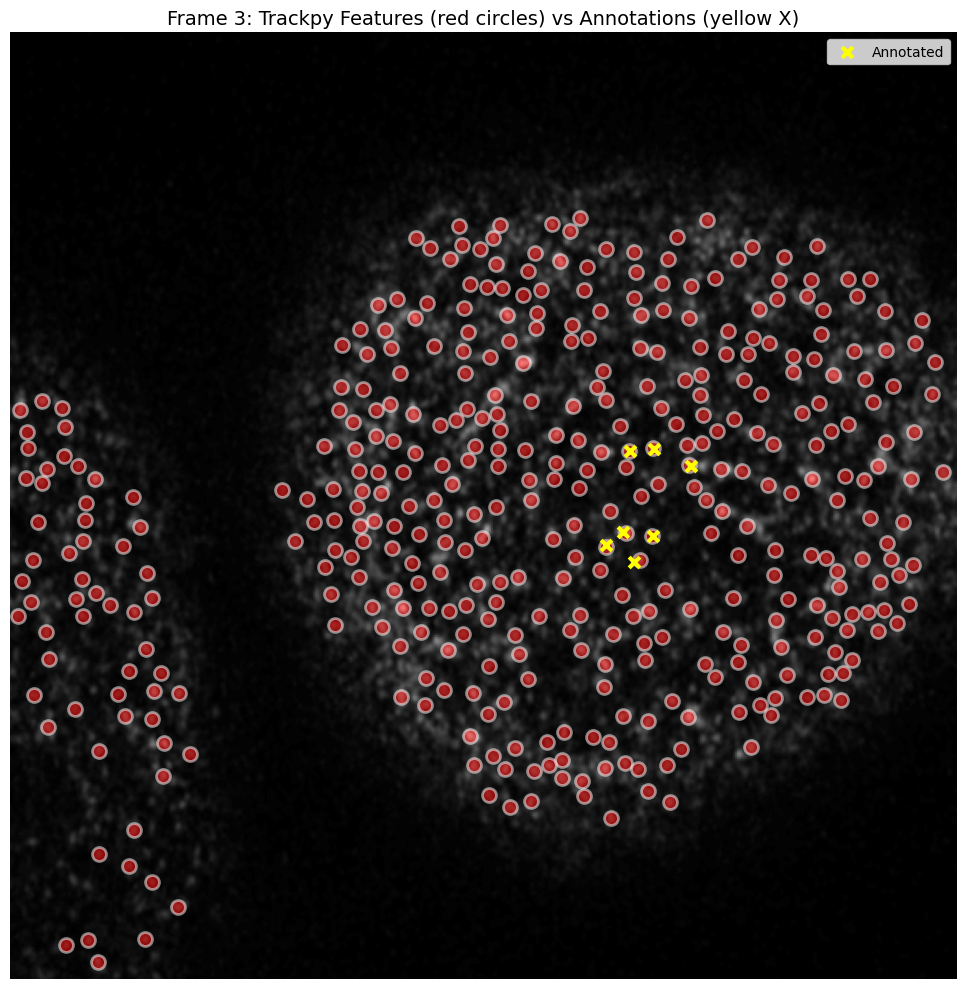

Detected 404 features


In [12]:
# Visualize a single frame with detected features
frame_idx = 3
frame = (rgb_stack[frame_idx][..., 0] * 255).astype(np.uint8)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(frame, cmap='gray')

# Show detected features
frame_features = all_features[all_features['frame'] == frame_idx]
ax.scatter(frame_features['x'], frame_features['y'], c='red', s=100, alpha=0.5, edgecolors='white', linewidths=2)

# Show annotated points
ann_points = points[points['frame'] == frame_idx]
ax.scatter(ann_points['x'], ann_points['y'], c='yellow', s=60, marker='x', linewidths=3, label='Annotated')

ax.set_title(f'Frame {frame_idx}: Trackpy Features (red circles) vs Annotations (yellow X)', fontsize=14)
ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Detected {len(frame_features)} features")

In [13]:
# Animate trackpy tracked vs annotated points
import matplotlib.animation as animation
from IPython.display import HTML

# Prepare data - filter to tracked frame range
tracked_frames = tracked_df['frame'].unique()
min_tracked = tracked_frames.min()
max_tracked = tracked_frames.max()

annotated_df = points.copy()
annotated_df = annotated_df[annotated_df['cut'] == False]
annotated_df = annotated_df[(annotated_df['frame'] >= min_tracked) & (annotated_df['frame'] <= max_tracked)]
annotated_df = annotated_df[['frame', 'point_id', 'x', 'y']]

tracked_df_sorted = tracked_df.sort_values(['frame', 'point_id'])
annotated_df_sorted = annotated_df.sort_values(['frame', 'point_id'])

# Use all tracked frames
frames = sorted(tracked_df_sorted['frame'].unique())

print(f"Animating {len(frames)} frames (frames {frames[0]} to {frames[-1]})")

fig = plt.figure(figsize=(8, 8))

def animate(i):
    plt.clf()
    frame = frames[i]
    
    # Background image
    bg_img = rgb_stack[frame][..., 0]
    plt.imshow(bg_img, cmap='gray', alpha=0.7)
    
    # Annotated points
    ann_pts = annotated_df_sorted[annotated_df_sorted['frame'] == frame]
    plt.scatter(ann_pts['x'], ann_pts['y'], c='red', label='Annotated', s=80, edgecolors='white', linewidths=2, alpha=0.8)
    
    # Trackpy tracked points
    trk_pts = tracked_df_sorted[tracked_df_sorted['frame'] == frame]
    plt.scatter(trk_pts['x'], trk_pts['y'], c='lime', label='Trackpy', s=60, marker='+', linewidths=3, alpha=0.9)
    
    plt.title(f'Frame {frame} | Ann: {len(ann_pts)} | Tracked: {len(trk_pts)}', fontsize=16)
    plt.legend(loc='upper right', fontsize=12)
    plt.xlim(0, bg_img.shape[1])
    plt.ylim(bg_img.shape[0], 0)
    plt.axis('off')

ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=300, repeat=False)

html = HTML(ani.to_jshtml())
plt.close(fig)

html

Animating 11 frames (frames 3 to 13)


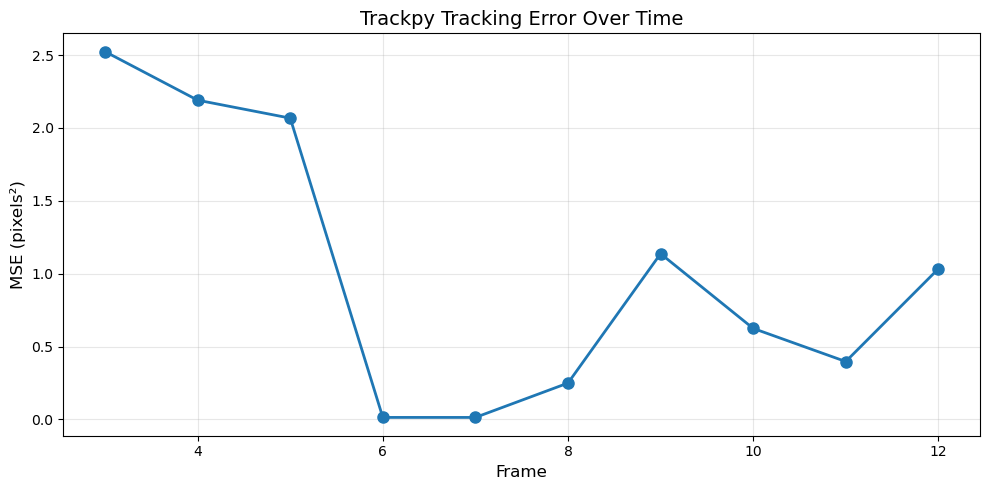

Overall MSE: 1.49 pixels²
Overall RMSE: 1.22 pixels


In [14]:
# Calculate and plot MSE over time
annotated_df = points.copy()
annotated_df = annotated_df[['frame', 'point_id', 'x', 'y']]
merged = pd.merge(tracked_df, annotated_df, on=['frame', 'point_id'], suffixes=('_tracked', '_annotated'))

# Compute squared error
merged['se'] = (merged['x_tracked'] - merged['x_annotated'])**2 + (merged['y_tracked'] - merged['y_annotated'])**2

# MSE per frame
mse_per_frame = merged.groupby('frame')['se'].mean()

plt.figure(figsize=(10, 5))
plt.plot(mse_per_frame.index, mse_per_frame.values, marker='o', linewidth=2, markersize=8)
plt.xlabel('Frame', fontsize=12)
plt.ylabel('MSE (pixels²)', fontsize=12)
plt.title('Trackpy Tracking Error Over Time', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Overall MSE: {merged['se'].mean():.2f} pixels²")
print(f"Overall RMSE: {np.sqrt(merged['se'].mean()):.2f} pixels")

## Track all cells

In [15]:
# Loop over all cells and run trackpy tracking
all_points = Points.from_csv('../out/points.csv')
cellids = all_points['cell_id'].unique()

results = []

for idx, cellid in enumerate(cellids):
    try:
        # Load cell-specific data
        cell_points = all_points.points_by_cell(cellid)
        if cell_points.empty:
            print(f"Skipping {cellid}: no points")
            continue
        
        # Load images
        image_dir = f'../data/ablation-czi/{cellid}.czi'
        with czi.CziFile(image_dir) as image_czi:
            image_data = image_czi.asarray()
        
        channel_red = np.squeeze(image_data[:, :, 0, :, :, :, :, :])
        channel_red_norm = channel_red / channel_red.max()
        num_slices, height, width = channel_red_norm.shape
        
        # Get annotated frame range - track for full duration of annotations
        annotated_frames = cell_points['frame'].unique()
        min_frame = int(annotated_frames.min())
        max_frame = int(annotated_frames.max())
        
        # Detect features in all annotated frames
        features_list = []
        for frame_idx in range(min_frame, max_frame + 1):
            frame = (channel_red_norm[frame_idx] * 255).astype(np.uint8)
            features = tp.locate(frame, diameter=diameter, minmass=minmass, separation=separation)
            features['frame'] = frame_idx
            features_list.append(features)
        
        all_features = pd.concat(features_list, ignore_index=True)
        
        # Link features
        trajectories = tp.link(all_features, search_range=search_range, memory=memory)
        
        # Match to annotated points
        annotated_first_frame = cell_points[cell_points['frame'] == cell_points['frame'].min()].copy()
        trackpy_first_frame = trajectories[trajectories['frame'] == trajectories['frame'].min()].copy()
        
        matches = []
        for _, ann_point in annotated_first_frame.iterrows():
            distances = np.sqrt((trackpy_first_frame['x'] - ann_point['x'])**2 + 
                               (trackpy_first_frame['y'] - ann_point['y'])**2)
            
            if len(distances) > 0:
                closest_idx = distances.idxmin()
                closest_dist = distances.min()
                
                if closest_dist < match_threshold:
                    matches.append({
                        'point_id': ann_point['point_id'],
                        'particle': trackpy_first_frame.loc[closest_idx, 'particle'],
                        'distance': closest_dist
                    })
        
        matches_df = pd.DataFrame(matches)
        
        # Create tracked dataframe
        tracked_points_list = []
        for _, match in matches_df.iterrows():
            particle_traj = trajectories[trajectories['particle'] == match['particle']].copy()
            particle_traj['point_id'] = match['point_id']
            tracked_points_list.append(particle_traj[['point_id', 'frame', 'x', 'y']])
        
        if tracked_points_list:
            tracked_df = pd.concat(tracked_points_list, ignore_index=True)
            
            # Filter cell_points to only include tracked frame range
            cell_points_filtered = cell_points[(cell_points['frame'] >= min_frame) & 
                                               (cell_points['frame'] <= max_frame)].copy()
            
            # Merge with annotations
            annotated_df = cell_points_filtered[['frame', 'point_id', 'x', 'y', 'cut']].copy()
            annotated_df.rename(columns={'x': 'x_ann', 'y': 'y_ann'}, inplace=True)
            
            # Left merge to keep all annotated points
            merged = pd.merge(annotated_df, tracked_df, on=['frame', 'point_id'], how='left')
            
            # For cut points, use annotated coordinates
            merged.loc[merged['cut'] == True, 'x'] = merged.loc[merged['cut'] == True, 'x_ann']
            merged.loc[merged['cut'] == True, 'y'] = merged.loc[merged['cut'] == True, 'y_ann']
            
            merged['cell_id'] = cellid
            merged = merged[['cell_id', 'point_id', 'frame', 'x', 'y', 'cut']]
            
            results.append(merged)
        
        num_frames = max_frame - min_frame + 1
        print(f'Progress {idx+1}/{len(cellids)} | Cell {cellid} | Frames {min_frame}-{max_frame} ({num_frames}) | Matched {len(matches_df)} points')
        clear_output(wait=True)
        
    except Exception as e:
        print(f"Error processing {cellid}: {str(e)}")
        continue

results_df = pd.concat(results, ignore_index=True)
print(f"\nCompleted! Tracked {results_df['point_id'].nunique()} unique points across {results_df['cell_id'].nunique()} cells")
results_df.head()


Completed! Tracked 1689 unique points across 158 cells


cell_id  point_id  frame           x           y    cut
0  220530-E1_Out         0      3  367.318741  190.392157  False
1  220530-E1_Out         0      4  370.865175  191.984281  False
2  220530-E1_Out         0      5  371.927497  192.508892  False
3  220530-E1_Out         0      6  373.029221  194.598214  False
4  220530-E1_Out         0      7  373.765265  192.077341  False

In [16]:
results_df.to_csv('../out/trackpy_points.csv', index=False)
print("Saved to ../out/trackpy_points.csv")

Saved to ../out/trackpy_points.csv
